In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
learning_rate = 0.0001
batch_size = 128
epochs = 1500

image_dim = 784
gen_hidden_dim = 256
disc_hidden_dim = 256
z_noise_dim = 100

In [ ]:
def xavier_init(shape):
  return tf.random.normal(shape=shape, stddev=1./tf.sqrt(shape[0] / 2.0))

In [ ]:
weights = None
bias = None

In [ ]:
class Discriminator(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.disc_H = tf.Variable(xavier_init([image_dim,disc_hidden_dim]), name="disc_H")
    self.disc_final = tf.Variable(xavier_init([disc_hidden_dim,1]), name="disc_final")
    self.disc_H_bias = tf.Variable(xavier_init([disc_hidden_dim]), name="disc_H_bias")
    self.disc_final_bias = tf.Variable(xavier_init([1]), name="disc_final_bias")

  def __call__(self, x):
    hidden_layer = tf.nn.relu(tf.add(tf.matmul(x,self.disc_H),self.disc_H_bias))
    final_layer = tf.add(tf.matmul(hidden_layer,self.disc_final),self.disc_final_bias)
    return final_layer


class Generator(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.gen_H = tf.Variable(xavier_init([z_noise_dim,gen_hidden_dim]), name="gen_H")
    self.gen_final = tf.Variable(xavier_init([gen_hidden_dim,image_dim]), name="gen_final")
    self.gen_H_bias = tf.Variable(xavier_init([gen_hidden_dim]), name="gen_H_bias")
    self.gen_final_bias = tf.Variable(xavier_init([image_dim]), name="gen_final_bias")

  def __call__(self, x):
    hidden_layer = tf.nn.relu(tf.add(tf.matmul(x,self.gen_H),self.gen_H_bias))
    final_layer = tf.add(tf.matmul(hidden_layer,self.gen_final),self.gen_final_bias)
    gen_output = tf.nn.sigmoid(final_layer)
    return gen_output

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)
    fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_output), logits=fake_output)
    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    return total_loss

def generator_loss(fake_output):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_output), logits=fake_output))

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
generator = Generator()
discriminator = Discriminator()


@tf.function
def train_step(images):

    current_batch_size = tf.shape(images)[0]

    images = tf.cast(images, tf.float32) / 255.0

    images = tf.reshape(images, [current_batch_size, image_dim])

    noise = tf.random.normal([current_batch_size, z_noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)

        real_output = discriminator(images)
        fake_output = discriminator(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    return gen_loss, disc_loss


train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)

for epoch in range(epochs):
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

Epoch 0, Generator Loss: 1.8366121053695679, Discriminator Loss: 0.4815433621406555
Epoch 100, Generator Loss: 2.077503204345703, Discriminator Loss: 0.5656257271766663
Epoch 200, Generator Loss: 2.1281673908233643, Discriminator Loss: 0.5438065528869629
Epoch 300, Generator Loss: 1.5378843545913696, Discriminator Loss: 0.9243215322494507
Epoch 400, Generator Loss: 2.016909599304199, Discriminator Loss: 0.7179862260818481
Epoch 500, Generator Loss: 1.567596435546875, Discriminator Loss: 0.8275289535522461
Epoch 600, Generator Loss: 1.4580078125, Discriminator Loss: 1.003574252128601
Epoch 700, Generator Loss: 1.375097393989563, Discriminator Loss: 1.036146879196167
Epoch 800, Generator Loss: 1.1911474466323853, Discriminator Loss: 1.2280359268188477
Epoch 900, Generator Loss: 1.0900911092758179, Discriminator Loss: 1.0607554912567139
Epoch 1000, Generator Loss: 1.2533031702041626, Discriminator Loss: 0.9995427131652832
Epoch 1100, Generator Loss: 1.434385895729065, Discriminator Loss: 

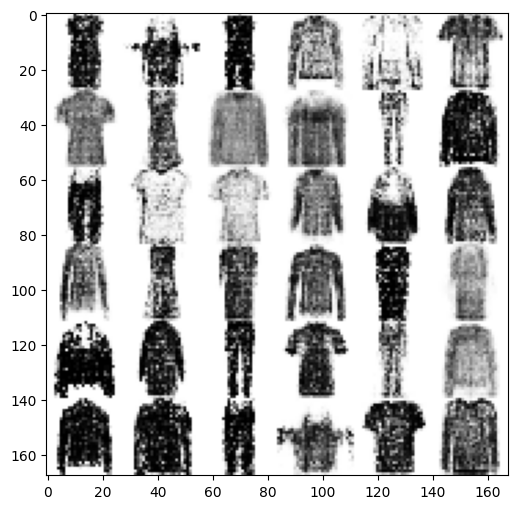

In [ ]:
n = 6
canvas = np.empty((28*n, 28*n))

for i in range(n):
  z_noise = tf.random.normal([n*n, z_noise_dim])
  generated_images = generator(z_noise)
  generated_images = generated_images.numpy()
  generated_images = -1*(generated_images-1)
  for j in range(n):
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = generated_images[j].reshape([28, 28])

plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()

In [ ]:
import os

save_path = "./gan_generator_model"

tf.saved_model.save(generator, save_path)

print(f"Generator model saved to: {save_path}")

Generator model saved to: ./gan_generator_model


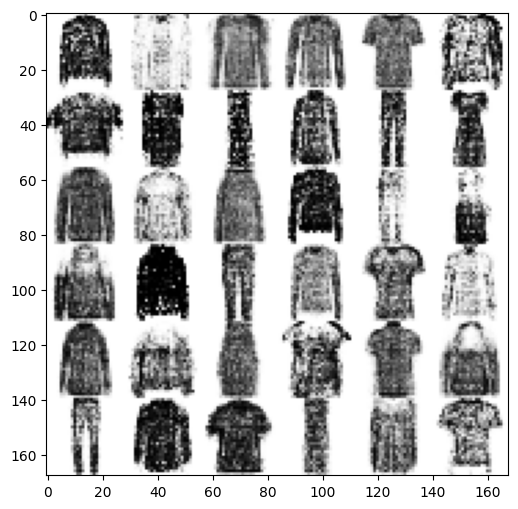

In [ ]:

loaded_generator = Generator()



dummy_noise = tf.random.normal([1, z_noise_dim])
_ = loaded_generator(dummy_noise)


loaded_model_obj = tf.saved_model.load(save_path)


loaded_generator.gen_H.assign(loaded_model_obj.gen_H)
loaded_generator.gen_final.assign(loaded_model_obj.gen_final)
loaded_generator.gen_H_bias.assign(loaded_model_obj.gen_H_bias)
loaded_generator.gen_final_bias.assign(loaded_model_obj.gen_final_bias)


n = 6
canvas = np.empty((28*n, 28*n))

for i in range(n):
  z_noise = tf.random.normal([n*n, z_noise_dim])

  generated_images = loaded_generator(z_noise)
  generated_images = generated_images.numpy()
  generated_images = -1*(generated_images-1)
  for j in range(n):
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = generated_images[i*n+j].reshape([28, 28])

plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()